# Example usage of gw_eccentricity

### Get the available methods

We implement different methods to measure eccentricity and mean anomaly

In [1]:
from gw_eccentricity.gw_eccentricity import get_available_methods

In [2]:
list(get_available_methods().keys())

['Amplitude',
 'Frequency',
 'ResidualAmplitude',
 'ResidualFrequency',
 'FrequencyFits']

### Measure eccentricity and mean anomaly

In [3]:
from gw_eccentricity.gw_eccentricity import measure_eccentricity

Read documentation

In [4]:
?measure_eccentricity

Signature:
measure_eccentricity(
    tref_in=None,
    fref_in=None,
    dataDict=None,
    method='Amplitude',
    return_ecc_method=False,
    spline_kwargs=None,
    extra_kwargs=None,
)
Docstring:
Measure eccentricity and mean anomaly at reference time.

parameters:
----------
tref_in:
    Input reference time at which to measure eccentricity and mean anomaly.
    Can be a single float or an array. NOTE: eccentricity/mean_ano are
    returned on a different time array tref_out, described below.

    If dataDict is provided in dimensionless units, then tref_in should be
    in units of M. If dataDict is provided in MKS units, tref_in should be
    in seconds.

fref_in:
    Input reference frequency at which to measure the eccentricity and
    mean anomaly. It can be a single float or an array.
    NOTE: eccentricity/mean anomaly are returned on a different freq
    array fref_out, described below.

    If dataDict is provided in dimensionless units, then fref_in should be
    in uni

### Create data dictionary 

For an example we use an eccentric waveform from the SXS catalog and the corresponding zero eccentricity waveform using NR Hybrid surrogate

In [5]:
import h5py

In [6]:
f = h5py.File("SXS_BBH_2305_22.h5", "r")
dataDict = {"t": f["t"][:],
           "hlm": {(2, 2): f["h22"][:]},
           "t_zeroecc": f["t_zeroecc"][:],
           "hlm_zeroecc": {(2, 2): f["h22_zeroecc"][:]}}
f.close()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from gw_eccentricity.plot_settings import use_fancy_plotsettings

In [8]:
use_fancy_plotsettings(journal="Notebook")

Text(0, 0.5, '$A_{22}$')

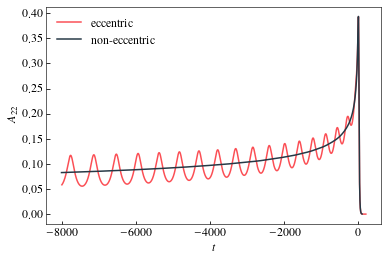

In [9]:
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label="eccentric")
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label="non-eccentric")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$A_{22}$")

#### Measure at a single time

In [10]:
tref_in = -5500
for method in get_available_methods():
    tref_out, ecc_ref, meanAno_ref = measure_eccentricity(tref_in=tref_in,
                                                         method=method,
                                                         dataDict=dataDict,
                                                         extra_kwargs={"debug": False})
    print(f"{method:20s}", f"{ecc_ref:.10f}", f"{meanAno_ref:.10f}")

Amplitude            0.1784605520 4.9150099733
Frequency            0.1784357809 4.9159228513
ResidualAmplitude    0.1784870190 4.9194417739
ResidualFrequency    0.1784894958 4.9214723879
FrequencyFits        0.1785157246 4.9212318026


#### Measure at a single frequency

In [12]:
fref_in = 0.005
for method in get_available_methods():
    fref_out, ecc_ref, meanAno_ref = measure_eccentricity(fref_in=fref_in,
                                                         method=method,
                                                         dataDict=dataDict,
                                                         extra_kwargs={"debug": False})
    print(f"{method:20s}", f"{ecc_ref:.10f}", f"{meanAno_ref:.10f}")

Amplitude            0.1716085706 5.0257598444
Frequency            0.1716024933 5.0225337580
ResidualAmplitude    0.1716282030 5.0303007649
ResidualFrequency    0.1716334686 5.0358984865
FrequencyFits        0.1716269601 5.0352866179


**NOTE:** In the similar way, one can measure the eccentricity and mean anomaly at an array of times/frequencies also.

### Making diagnostic plots

The library comes with useful way to make diagnostic plots when the resulting eccentricty does not look good. Each of the plots could be used to investigate different issues that might be causing the unwanted features in the measured eccentricity.

For demonstration purpose, let's try measuring the eccentricity at an array of times using only `ResidualAmplitude` method

In [14]:
tref_in = dataDict["t"]

The diagnostic plots are available through the eccentricity measurement module object. Therefore, we return this object this time as well

In [15]:
method = "ResidualAmplitude"
tref_out, ecc_ref, meanAno_ref, eccMethod = measure_eccentricity(tref_in=tref_in,
                                                                 method=method,
                                                                 dataDict=dataDict,
                                                                 return_ecc_method=True,
                                                                 extra_kwargs={"debug": False})

/home/arif/miniconda3/envs/ecc/lib/python3.9/site-packages/gw_eccentricity/eccDefinition.py:463: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


(-0.00038296915510739257, 0.16)

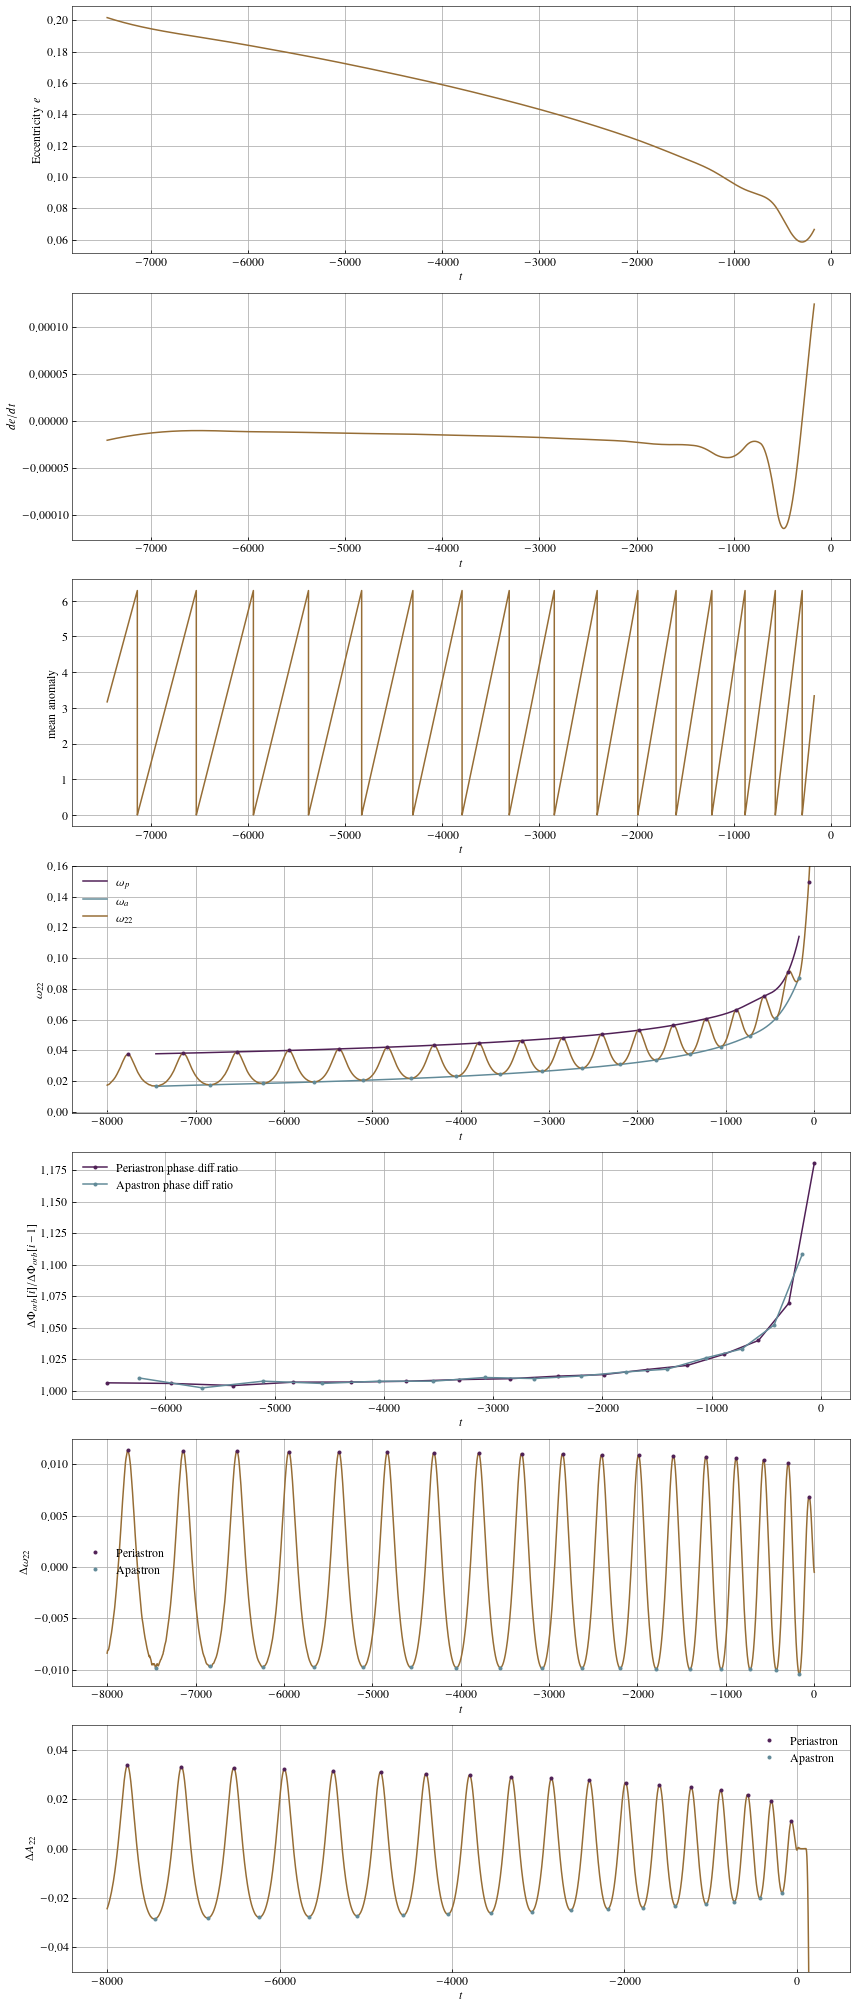

In [18]:
fig, ax = eccMethod.make_diagnostic_plots()
ax[6].set_ylim(-0.05, 0.05)
ax[3].set_ylim(top=0.16)

Let's look at each of these plots separately.

**Eccentricity vs Time:**

This plot shows the evolution of eccentricity as a function of time.

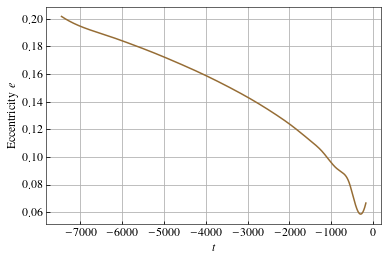

In [35]:
fig, ax = eccMethod.plot_measured_ecc()

**$de/dt$ vs Time:**

This plot shows the first derivative of eccentricity as a function of time. The eccentricity should be a monotonically decreasing function of time. Therefore, wherever $de/dt$ becomes positive implies non-monotonic eccentricity due unphysical features.

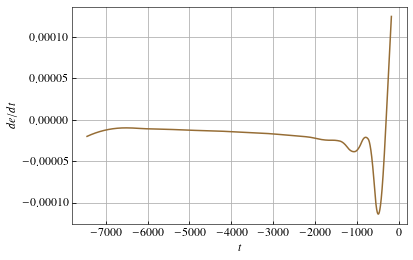

In [34]:
fig, ax = eccMethod.plot_decc_dt()

**Mean anomaly vs Time:**

This plot shows the evolution of mean anomaly as a function of time

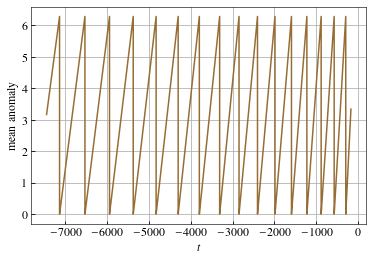

In [33]:
fig, ax = eccMethod.plot_mean_ano()

**$\omega_{22}$ with the locations of apocenter and pericenter**

This plot shows the $\omega_{22}(t)$ with the locations of the apocenters and pericenters that are being used for measuring eccentricity indicated by circles.<br>
This would show if the method is missing any peaks/troughs or selecting one which is not a peak/trough.

(-0.00038296915510739257, 0.16)

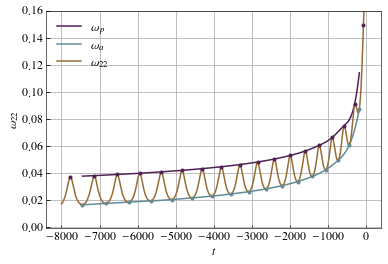

In [23]:
fig, ax = eccMethod.plot_extrema_in_omega22()
ax.set_ylim(top=0.16)

**Ratio of $\Delta \phi_{\mathrm{orb}}$ between consecutive peaks/troughs vs Time:**

$\Delta \phi_{\mathrm{orb}}^{i}/\Delta \phi_{\mathrm{orb}}^{i-1}$, where $\Delta \phi_{\mathrm{orb}}^{i}$
is the change in orbital phase from the previous extrema to the ith extrema. This helps look for missing extrema, as there will be a drastic (roughly factor of 2) change in
$\Delta \phi_{\mathrm{orb}}^{i}$ if there is a missing extrema, and the ratio will go from ~1 to ~2.

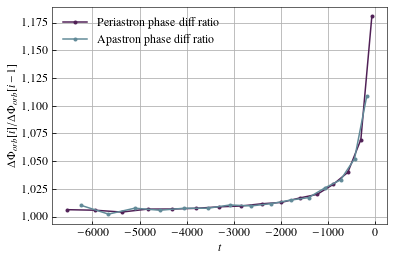

In [32]:
fig, ax = eccMethod.plot_phase_diff_ratio_between_peaks()

**$\Delta A_{22}$ vs Time:**

$\Delta A_{22}$ is the residual amplitude of the 22 mode, defined as $\Delta A_{22} = A_{22}(e) - A_{22}(e=0)$, where we substract the 22 mode amplitude of the qausi-circular waveform (generated using the same set of parameters as the eccentric one, except we set the eccentricity to be zero) from the 22 mode amplitude of the eccentric waveform.
**NOTE:** This is available only if the provided data dictionary contains zeroecc data.

(-0.05, 0.05)

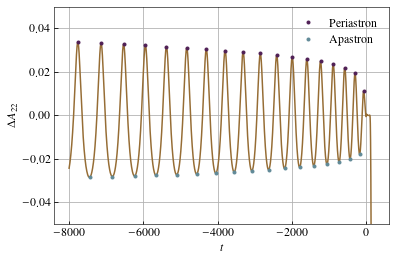

In [29]:
fig, ax = eccMethod.plot_residual_amp22()
ax.set_ylim(-0.05, 0.05)

**$\Delta \omega_{22}$ vs Time:**

$\Delta \omega_{22}$ is the residual omega of the 22 mode, defined as $\Delta \omega_{22} = \omega_{22}(e) - \omega_{22}(e=0)$, where we substract the 22 mode omega of the qausi-circular waveform (generated using the same set of parameters as the eccentric one, except we set the eccentricity to be zero) from the 22 mode omega of the eccentric waveform.
**NOTE:** This is available only if the provided data dictionary contains zeroecc data.

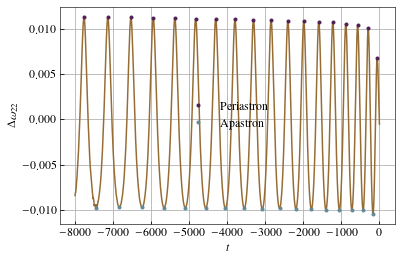

In [31]:
fig, ax = eccMethod.plot_residual_omega22()